In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from nltk.tokenize import word_tokenize
import nltk
from collections import Counter
nltk.download('punkt')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
!pip install datasets transformers==4.18.0 sentencepiece
from datasets import load_dataset, load_metric, DatasetDict, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from tokenizers import BertWordPieceTokenizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import recall_score, precision_score, f1_score

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
train_data = pd.read_csv("train_E6oV3lV.csv")

In [5]:
train_data.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


In [7]:
test_data = pd.read_csv("test_tweets_anuFYb8.csv")

In [8]:
test_data.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


In [9]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17197 entries, 0 to 17196
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      17197 non-null  int64 
 1   tweet   17197 non-null  object
dtypes: int64(1), object(1)
memory usage: 268.8+ KB


In [10]:
print("Train Data")
print("Number of Observations : ",train_data.shape[0])
print("Number of Features : ",train_data.shape[1])

print("Test Data")
print("Number of Observations : ",test_data.shape[0])
print("Number of Features : ",test_data.shape[1])

Train Data
Number of Observations :  31962
Number of Features :  3
Test Data
Number of Observations :  17197
Number of Features :  2


In [11]:
train_data.columns

Index(['id', 'label', 'tweet'], dtype='object')

In [12]:
print("Training Data data types")
print(train_data.dtypes)

Training Data data types
id        int64
label     int64
tweet    object
dtype: object


In [13]:
print("Test Data data types")
print(test_data.dtypes)

Test Data data types
id        int64
tweet    object
dtype: object


In [14]:
train_data.describe()

,id,label
count,31962.000000,31962.000000
mean,15981.500000,0.070146
std,9226.778988,0.255397
min,1.000000,0.000000
25%,7991.250000,0.000000
50%,15981.500000,0.000000
75%,23971.750000,0.000000
max,31962.000000,1.000000


In [15]:
test_data.describe()

,id
count,17197.000000
mean,40561.000000
std,4964.490625
min,31963.000000
25%,36262.000000
50%,40561.000000
75%,44860.000000
max,49159.000000


In [16]:
hate_speech = train_data[train_data['label'] == 1].shape[0]
free_speech = train_data[train_data['label'] == 0].shape[0]
print('Hate Speech =', hate_speech)
print('Free Speech =', free_speech)

Hate Speech = 2242
Free Speech = 29720


In [17]:
train_data.isna().sum()

id       0
label    0
tweet    0
dtype: int64

In [18]:
test_data.isna().sum()

id       0
tweet    0
dtype: int64

# Data Preprocessing

## Convertion to Lowercase

In [19]:
def to_lower_case(text):
    return text.lower()

train_data['tweet'] = train_data['tweet'].apply(to_lower_case)
test_data['tweet'] = test_data['tweet'].apply(to_lower_case)

## Removing the Punctuation

In [20]:
def remove_punct(text):
    return text.translate(str.maketrans('','',string.punctuation))

train_data['tweet'] = train_data['tweet'].apply(remove_punct)
test_data['tweet'] = test_data['tweet'].apply(remove_punct)

## Removing the Special Characters

In [21]:
def remove_special(text):
    return " ".join(e for e in text.split() if e.isalnum())

train_data['tweet'] = train_data['tweet'].apply(remove_special)
test_data['tweet'] = test_data['tweet'].apply(remove_special)

## Removing the @ Mentions

In [22]:
def remove_tag(text):
    newtext= re.sub(r'(@[A-Za-z0-9]+)',"",text)
    return newtext

train_data['tweet'] = train_data['tweet'].apply(remove_tag)
test_data['tweet'] = test_data['tweet'].apply(remove_tag)

## Removing the Stopwords and stemming

**Stemming is nothing but reducing words to their base or root form.**

In [23]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [24]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

In [25]:
def rem_stop_words_stem(text):
  words = text.split()
  processed_words = [stemmer.stem(word) for word in words if word.lower() not in stop_words]
  return ' '.join(processed_words)

train_data['tweet'] = train_data['tweet'].apply(rem_stop_words_stem)
test_data['tweet'] = test_data['tweet'].apply(rem_stop_words_stem)

In [26]:
train_data.head(10)

,id,label,tweet
0,1,0,user father dysfunct selfish drag kid dysfunct...
1,2,0,user user thank lyft credit cant use caus dont...
2,3,0,bihday majesti
3,4,0,model love u take u time
4,5,0,factsguid societi motiv
5,6,0,22 huge fan fare big talk leav chao pay disput...
6,7,0,user camp tomorrow user user user user user us...
7,8,0,next school year year cant think school exam h...
8,9,0,love land allin cav champion cleveland clevela...
9,10,0,user user welcom im gr8


In [27]:
test_data.head()

,id,tweet
0,31963,studiolif aislif requir passion dedic willpow ...
1,31964,user white supremacist want everyon see new movi
2,31965,safe way heal acn altwaystoh healthi heal
3,31966,hp curs child book reserv alreadi ye harrypott...
4,31967,3rd bihday amaz hilari nephew eli ahmir uncl d...


# Featurization

## Bag of Words (BOW)

**Converts text into fixed-length vectors by counting the frequency of each word in the text, without considering the order or context of the words.**

In [28]:
vec = CountVectorizer()

train_bow = vec.fit_transform(train_data['tweet'])
test_bow = vec.transform(test_data['tweet'])

In [29]:
train_bow_shape = train_bow.shape
print('BOW featurized train data shape : ',train_bow_shape)
test_bow_shape = test_bow.shape
print('BOW featurized test data shape : ',test_bow_shape)

BOW featurized train data shape :  (31962, 33950)
BOW featurized test data shape :  (17197, 33950)


## Term Frequency-Inverse Document Frequency (TF-IDF)

**Enhances the BoW model by weighting each word's frequency in a document against its frequency across all documents, emphasizing unique words that are more informative.**

In [30]:
tfidf_vec = TfidfVectorizer()

train_tfidf = tfidf_vec.fit_transform(train_data['tweet'])
test_tfidf = tfidf_vec.transform(test_data['tweet'])

In [31]:
train_tfidf_shape = train_tfidf.shape
print('TF-IDF featurized train data shape : ',train_tfidf_shape)
test_tfidf_shape = test_tfidf.shape
print('TF-IDF featurized test data shape : ',test_tfidf_shape)

TF-IDF featurized train data shape :  (31962, 33950)
TF-IDF featurized test data shape :  (17197, 33950)


## Word2Vec

**Represents words as continuous vectors in a high-dimensional space, capturing semantic meaning by training on word co-occurrence patterns, allowing for context-aware embeddings.**

In [32]:
train_data['tokenized_tweet'] = train_data['tweet'].apply(word_tokenize)
test_data['tokenized_tweet'] = test_data['tweet'].apply(word_tokenize)

In [33]:
train_data.head()

,id,label,tweet,tokenized_tweet
0,1,0,user father dysfunct selfish drag kid dysfunct...,"[user, father, dysfunct, selfish, drag, kid, d..."
1,2,0,user user thank lyft credit cant use caus dont...,"[user, user, thank, lyft, credit, cant, use, c..."
2,3,0,bihday majesti,"[bihday, majesti]"
3,4,0,model love u take u time,"[model, love, u, take, u, time]"
4,5,0,factsguid societi motiv,"[factsguid, societi, motiv]"


In [34]:
test_data.head()

,id,tweet,tokenized_tweet
0,31963,studiolif aislif requir passion dedic willpow ...,"[studiolif, aislif, requir, passion, dedic, wi..."
1,31964,user white supremacist want everyon see new movi,"[user, white, supremacist, want, everyon, see,..."
2,31965,safe way heal acn altwaystoh healthi heal,"[safe, way, heal, acn, altwaystoh, healthi, heal]"
3,31966,hp curs child book reserv alreadi ye harrypott...,"[hp, curs, child, book, reserv, alreadi, ye, h..."
4,31967,3rd bihday amaz hilari nephew eli ahmir uncl d...,"[3rd, bihday, amaz, hilari, nephew, eli, ahmir..."


In [35]:
model = gensim.models.Word2Vec(sentences=train_data['tokenized_tweet'], vector_size=100, window=5, min_count=1, workers=4)

model.save("word2vec.model")

In [36]:
def get_average_word2vec(tokens_list, model, vector_size):
    """
    Calculate the average word2vec for each document.
    """
    if len(tokens_list) < 1:
        return np.zeros(vector_size)
    vec = [model.wv[word] for word in tokens_list if word in model.wv]
    return np.mean(vec, axis=0) if len(vec) > 0 else np.zeros(vector_size)

In [37]:
vector_size = 100
train_vectors = np.array([get_average_word2vec(tokens, model, vector_size) for tokens in train_data['tokenized_tweet']])
test_vectors = np.array([get_average_word2vec(tokens, model, vector_size) for tokens in test_data['tokenized_tweet']])

In [38]:
train_vectors_shape = train_vectors.shape
print('Word2Vec featurized train data shape : ',train_vectors_shape)
test_vectors_shape = test_vectors.shape
print('Word2Vec featurized test data shape : ',test_vectors_shape)

Word2Vec featurized train data shape :  (31962, 100)
Word2Vec featurized test data shape :  (17197, 100)


# EDA

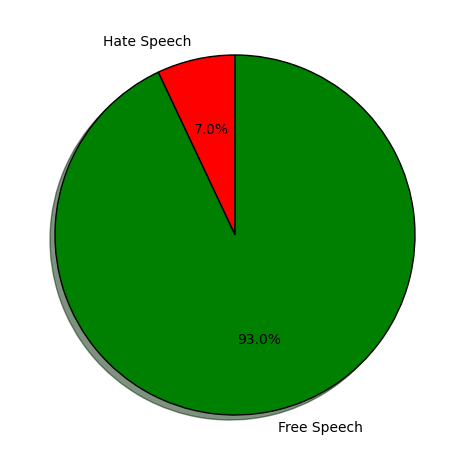

In [39]:
speech = [hate_speech, free_speech]
label = ["Hate Speech", "Free Speech"]

plt.pie(speech, labels = label, shadow = True, wedgeprops = {'edgecolor': 'black'},
        autopct = '%1.1f%%', startangle= 90, colors=['red', 'green'])

plt.tight_layout()
plt.show()

## Tweet Length Distribution

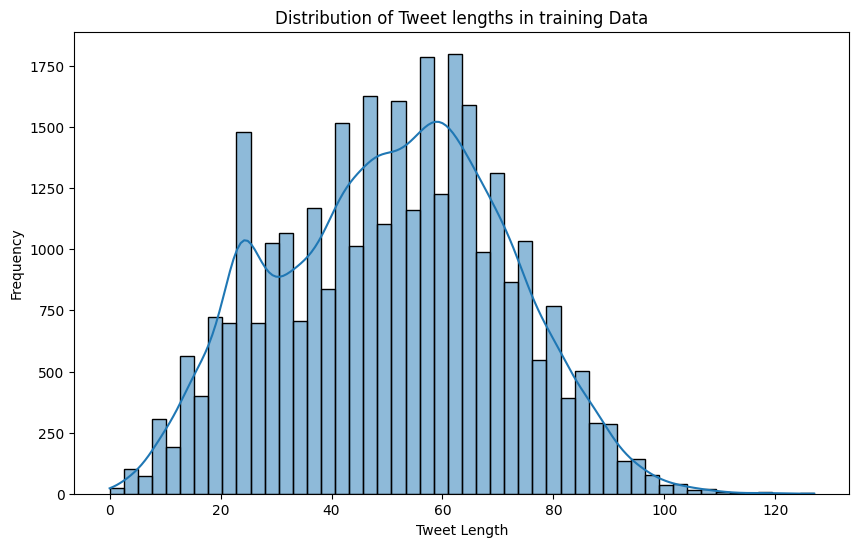

In [40]:
train_data['tweet_length'] = train_data['tweet'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(train_data['tweet_length'], bins=50, kde=True)
plt.title("Distribution of Tweet lengths in training Data")
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.show()

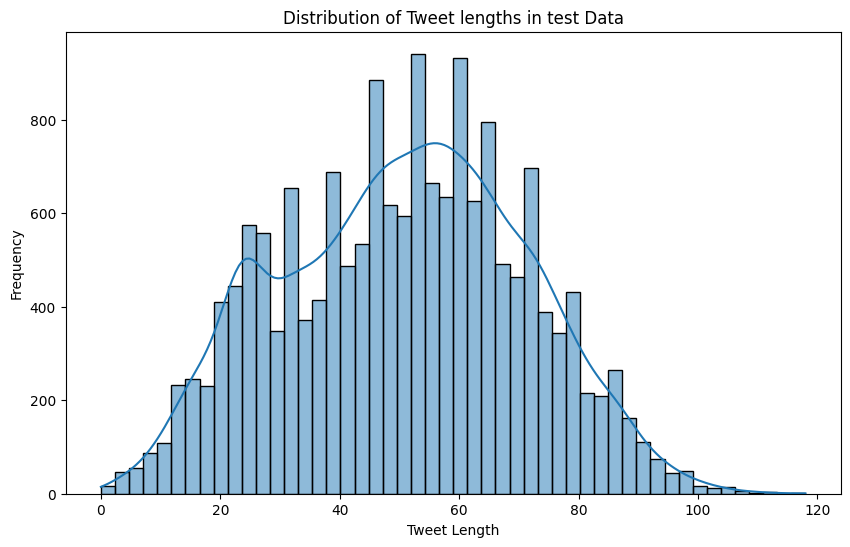

In [41]:
test_data['tweet_length'] = test_data['tweet'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(test_data['tweet_length'], bins=50, kde=True)
plt.title("Distribution of Tweet lengths in test Data")
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.show()

In [42]:
train_data

,id,label,tweet,tokenized_tweet,tweet_length
0,1,0,user father dysfunct selfish drag kid dysfunct...,"[user, father, dysfunct, selfish, drag, kid, d...",50
1,2,0,user user thank lyft credit cant use caus dont...,"[user, user, thank, lyft, credit, cant, use, c...",90
2,3,0,bihday majesti,"[bihday, majesti]",14
3,4,0,model love u take u time,"[model, love, u, take, u, time]",24
4,5,0,factsguid societi motiv,"[factsguid, societi, motiv]",23
...,...,...,...,...,...
31957,31958,0,ate user isz,"[ate, user, isz]",12
31958,31959,0,see nina turner airwav tri wrap mantl genuin h...,"[see, nina, turner, airwav, tri, wrap, mantl, ...",84
31959,31960,0,listen sad song monday morn otw work sad,"[listen, sad, song, monday, morn, otw, work, sad]",40
31960,31961,1,user sikh templ vandalis calgari wso condemn act,"[user, sikh, templ, vandalis, calgari, wso, co...",48


## Common Words

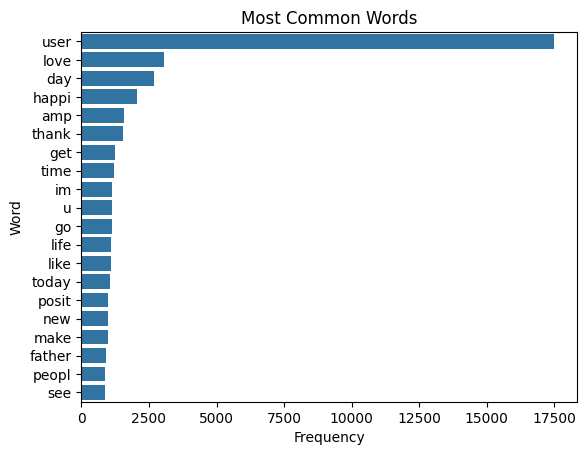

In [43]:
all_words = ' '.join([text for text in train_data['tweet']])
word_freq = Counter(all_words.split())
common_words = word_freq.most_common(20)

common_words_df = pd.DataFrame(common_words, columns=['Word', 'Frequency'])
sns.barplot(x='Frequency', y='Word', data=common_words_df)
plt.title('Most Common Words')
plt.show()

## Word Cloud

**Word Cloud is a visual representation of word frequency in a text. Words appear in different sizes, with larger words indicating more frequent mentions.**

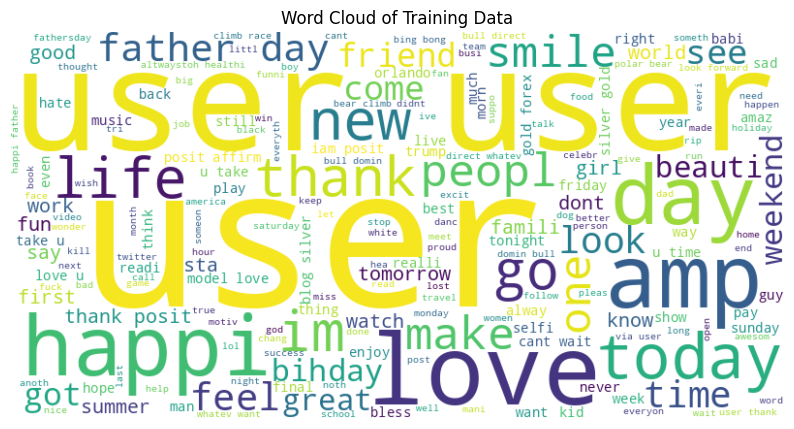

In [44]:
text = ' '.join(train_data['tweet'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Word Cloud of Training Data")
plt.axis('off')
plt.show()

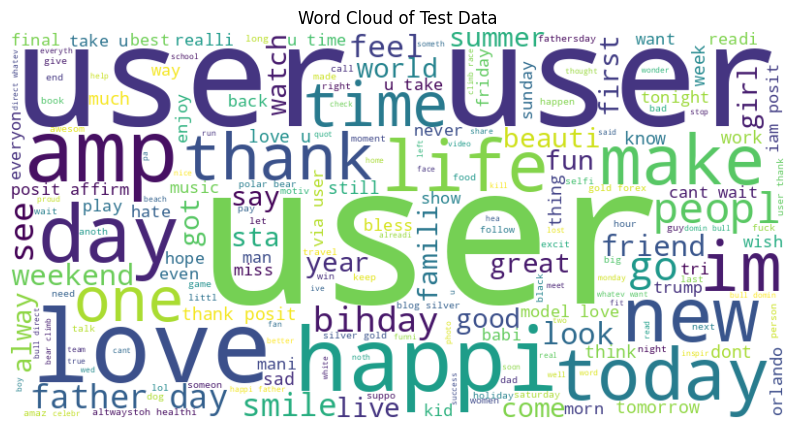

In [45]:
text = ' '.join(test_data['tweet'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Word Cloud of Test Data")
plt.axis('off')
plt.show()

## Class Distribution

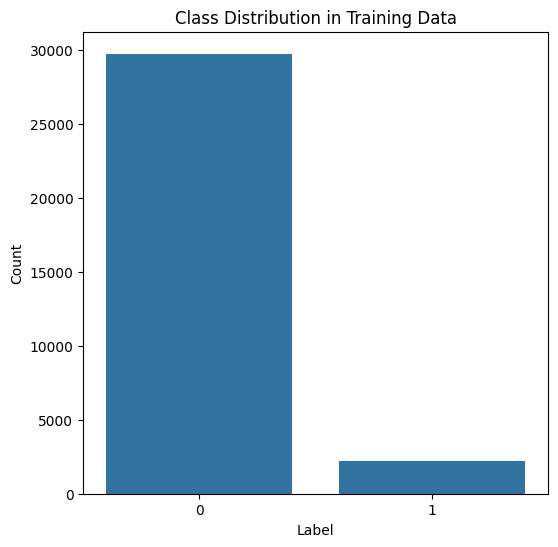

In [46]:
plt.figure(figsize=(6, 6))
sns.countplot(x='label', data=train_data)
plt.title('Class Distribution in Training Data')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

## Common Words by Class

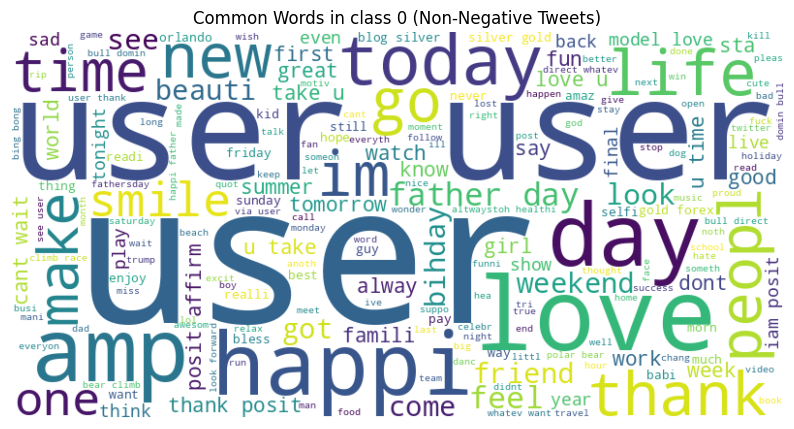

In [47]:
label = 0
text = ' '.join(train_data[train_data['label'] == label]['tweet'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Common Words in class 0 (Non-Negative Tweets)")
plt.axis('off')
plt.show()

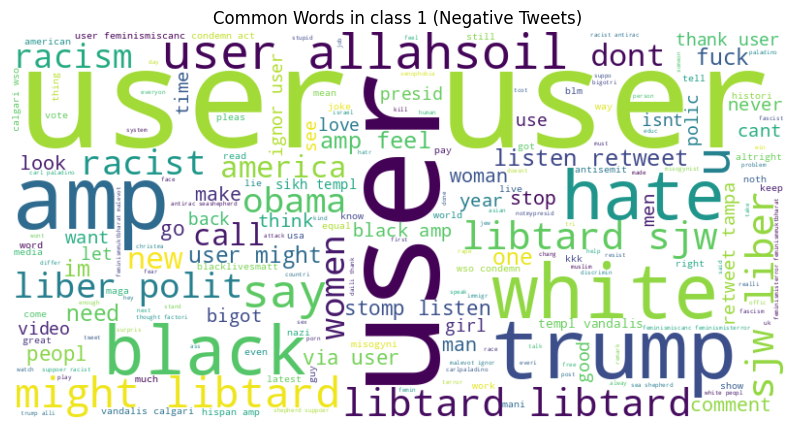

In [48]:
label = 1
text = ' '.join(train_data[train_data['label'] == label]['tweet'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Common Words in class 1 (Negative Tweets)")
plt.axis('off')
plt.show()

# Data Balancing

In [49]:
# Vectorize the text data using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X = tfidf_vectorizer.fit_transform(train_data['tweet'])
y = train_data['label']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [50]:

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print("Original class distribution:", Counter(y_train))
print("Resampled class distribution:", Counter(y_train_balanced))

Original class distribution: Counter({0: 23783, 1: 1786})
Resampled class distribution: Counter({1: 23783, 0: 23783})


# Modelling

## Linear Model

In [51]:
lr = LogisticRegression(class_weight='balanced', max_iter=1000)
lr.fit(X_train_balanced, y_train_balanced)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [52]:
y_pred_lr = lr.predict(X_val)
print("Accuracy For Logistic Regression : {}%".format(accuracy_score(y_val, y_pred_lr)*100))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred_lr))
print("Classification Report:\n", classification_report(y_val, y_pred_lr))

Accuracy For Logistic Regression : 93.43031440638198%
Confusion Matrix:
 [[5612  325]
 [  95  361]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.95      0.96      5937
           1       0.53      0.79      0.63       456

    accuracy                           0.93      6393
   macro avg       0.75      0.87      0.80      6393
weighted avg       0.95      0.93      0.94      6393



## Ensemble Model

In [53]:
rf = RandomForestClassifier(class_weight='balanced', n_estimators=100)
rf.fit(X_train_balanced, y_train_balanced)

RandomForestClassifier(class_weight='balanced')

In [54]:
y_pred_rf = rf.predict(X_val)
print("Accuracy For Random Forest : {}%".format(accuracy_score(y_val, y_pred_rf)*100))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred_rf))
print("Classification Report:\n", classification_report(y_val, y_pred_rf))

Accuracy For Random Forest : 95.88612544971062%
Confusion Matrix:
 [[5853   84]
 [ 179  277]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      5937
           1       0.77      0.61      0.68       456

    accuracy                           0.96      6393
   macro avg       0.87      0.80      0.83      6393
weighted avg       0.96      0.96      0.96      6393



## Boosting Model

In [55]:
gb = GradientBoostingClassifier()
gb.fit(X_train_balanced, y_train_balanced)

GradientBoostingClassifier()

In [56]:
y_pred_gb = gb.predict(X_val)
print("Accuracy For Gradient Boosting : {}%".format(accuracy_score(y_val, y_pred_gb)*100))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred_gb))
print("Classification Report:\n", classification_report(y_val, y_pred_gb))

Accuracy For Gradient Boosting : 91.25606131706554%
Confusion Matrix:
 [[5573  364]
 [ 195  261]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.94      0.95      5937
           1       0.42      0.57      0.48       456

    accuracy                           0.91      6393
   macro avg       0.69      0.76      0.72      6393
weighted avg       0.93      0.91      0.92      6393



## Transformers Model

In [57]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments

In [58]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [59]:
tokenizer

PreTrainedTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [60]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [61]:
model = model.to('cuda')

In [87]:
X = list(train_data['tweet'])
y = list(train_data['label'])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [88]:
X_train_tokenized = tokenizer(X_train, padding = True, truncation = True, max_length=512)
X_val_tokenized = tokenizer(X_val, padding = True, truncation = True, max_length=512)

In [89]:
X_train_tokenized.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [90]:
print(X_train_tokenized['input_ids'][0])

[101, 5310, 5310, 5310, 4921, 2063, 3477, 2012, 6528, 2102, 2627, 2095, 2620, 2095, 2002, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [91]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, encodings, labels=None):
    self.encodings = encodings
    self.labels = labels

  def __getitem__(self, idx):
    item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    if self.labels:
      item['labels'] = torch.tensor(self.labels[idx])
    return item

  def __len__(self):
    return len(self.encodings['input_ids'])

In [92]:
train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)

In [93]:
def compute_metrics(p):
    print(type(p))
    pred, labels = p
    pred = np.argmax(pred, axis=1)
    accuracy = np.mean(pred == labels)
    recall = recall_score(labels, pred)
    precision = precision_score(labels, pred)
    f1 = f1_score(labels, pred)
    return {'accuracy': accuracy, 'recall': recall, 'precision': precision, 'f1': f1}

In [95]:
args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,
    per_device_train_batch_size=8
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

In [96]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 25569
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3197


Step,Training Loss
500,0.283200
1000,0.294200
1500,0.289800
2000,0.274700
2500,0.280900
3000,0.288200


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1500
Configuration saved in ./results/checkpoint-1500/config.json
Model weights saved in ./results/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-2000
Configuration saved in ./results/checkpoint-2000/config.json
Model weights saved in ./results/checkpoint-2000/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-2500
Configuration saved in ./results/checkpoint-2500/config.json
Model weights saved in ./results/checkpoint-2500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-3000
Configuration saved in ./results/checkpoint-3

TrainOutput(global_step=3197, training_loss=0.28314670518595314, metrics={'train_runtime': 372.5329, 'train_samples_per_second': 68.636, 'train_steps_per_second': 8.582, 'total_flos': 604422621927720.0, 'train_loss': 0.28314670518595314, 'epoch': 1.0})

In [97]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 6393
  Batch size = 8


<class 'transformers.trainer_utils.EvalPrediction'>


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.29415658116340637,
 'eval_accuracy': 0.9286719849835758,
 'eval_recall': 0.0,
 'eval_precision': 0.0,
 'eval_f1': 0.0,
 'eval_runtime': 22.6097,
 'eval_samples_per_second': 282.754,
 'eval_steps_per_second': 35.383,
 'epoch': 1.0}

In [104]:
text = "I hate you"

In [105]:
inputs = tokenizer(text, padding = True, truncation = True, return_tensors='pt').to('cuda')

In [110]:
outputs = model(**inputs)
predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)

In [111]:
predictions = predictions.cpu().detach().numpy()

In [112]:
predictions

array([[0.97853935, 0.02146065]], dtype=float32)